In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.model_zoo as model_zoo
from model.propagation import mod_resnet

from torchvision import models
import cv2
import matplotlib.pyplot as plt
import math
def pad_divide_by(in_img, d, in_size=None):
    if in_size is None:
        h, w = in_img.shape[-2:]
    else:
        h, w = in_size

    if h % d > 0:
        new_h = h + d - h % d
    else:
        new_h = h
    if w % d > 0:
        new_w = w + d - w % d
    else:
        new_w = w
    lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
    lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
    pad_array = (int(lw), int(uw), int(lh), int(uh))
    out = F.pad(in_img, pad_array)
    return out, pad_array

# def do_pass(key_k, key_v, idx, certain_mem_k, certain_mem_v, interacted, t, mem_freq=5, forward=True, step_cb=None, device='cpu'):
#         """
#         Do a complete pass that includes propagation and fusion
#         key_k/key_v -  memory feature of the starting frame
#         idx - Frame index of the starting frame
#         forward - forward/backward propagation
#         step_cb - Callback function used for GUI (progress bar) only
#         """
#         global out_numpy
#         save_path = r'../Nov_18_masks*300/F%05d.png'
#         # Pointer in the memory bank
#         num_certain_keys = certain_mem_k.shape[2]
#         m_front = num_certain_keys

#         # Determine the required size of the memory bank
#         if forward:
#             closest_ti = min([ti for ti in interacted if ti > idx] + [t])
#             total_m = (closest_ti - idx - 1)//mem_freq + 1 + num_certain_keys
#         else:
#             closest_ti = max([ti for ti in interacted if ti < idx] + [-1])
#             total_m = (idx - closest_ti - 1)//mem_freq + 1 + num_certain_keys
#         K, CK, _, H, W = key_k.shape
#         _, CV, _, _, _ = key_v.shape
            
#         # Pre-allocate keys/values memory
#         keys = torch.empty((K, CK, total_m, H, W), dtype=torch.float32, device=device)
#         values = torch.empty((K, CV, total_m, H, W), dtype=torch.float32, device=device)

#         # Initial key/value passed in
# #         print(f'certain_keys={num_certain_keys}')
#         keys[:,:,0:num_certain_keys] = certain_mem_k
#         values[:,:,0:num_certain_keys] = certain_mem_v
#         prev_in_mem = True
#         last_ti = idx

#         # Note that we never reach closest_ti, just the frame before it
#         if forward:
#             this_range = range(idx+1, closest_ti)
# #             this_range = range(idx+1, closest_ti, 10)
#             step = +1
#             end = closest_ti - 1
#         else:
#             this_range = range(idx-1, closest_ti, -1)
# #             this_range = range(idx-1, closest_ti, -10)
#             step = -1
#             end = closest_ti + 1

#         for ti in this_range:
#             if prev_in_mem:
#                 this_k = keys[:,:,:m_front]
#                 this_v = values[:,:,:m_front]
#             else:
#                 this_k = keys[:,:,:m_front+1]
#                 this_v = values[:,:,:m_front+1]
#             query = prop_net.get_query_values(image[:, ti].to(device))
#             out_mask = prop_net.segment_with_query(this_k, this_v, *query)
#             out_mask = aggregate_wbg(out_mask, keep_bg=True)
#             out_numpy = out_mask.detach().cpu().numpy()
# #             print(f'frame {ti} mask is:')
#             plt.imsave(save_path%ti, out_mask[1, 0].detach().cpu().numpy())
# #             plt.imshow(out_mask[1, 0].detach().cpu().numpy())
# #             break
            

#             if ti != end:
#                 keys[:,:,m_front:m_front+1], values[:,:,m_front:m_front+1] = prop_net.memorize(
#                         image[:, ti].to(device), out_mask[1:])
#                 if abs(ti-last_ti) >= mem_freq:
#                     # Memorize the frame
#                     m_front += 1
#                     last_ti = ti
#                     prev_in_mem = True
#                 else:
#                     prev_in_mem = False
                    
        
                    
def aggregate_wbg(prob, keep_bg=False, hard=False):
    k, _, h, w = prob.shape
    new_prob = torch.cat([
        torch.prod(1-prob, dim=0, keepdim=True),
        prob
    ], 0).clamp(1e-7, 1-1e-7)
    logits = torch.log((new_prob /(1-new_prob)))

    if hard:
        # Very low temperature o((⊙﹏⊙))o 🥶
        logits *= 1000

    if keep_bg:
        return F.softmax(logits, dim=0)
    else:
        return F.softmax(logits, dim=0)[1:]
    
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.compress = ResBlock(1024, 512)
        self.up_16_8 = UpsampleBlock(512, 512, 256) # 1/16 -> 1/8
        self.up_8_4 = UpsampleBlock(256, 256, 256) # 1/8 -> 1/4

        self.pred = nn.Conv2d(256, 1, kernel_size=(3,3), padding=(1,1), stride=1)

    def forward(self, f16, f8, f4):
        x = self.compress(f16)
        x = self.up_16_8(f8, x)
        x = self.up_8_4(f4, x)

        x = self.pred(F.relu(x))
        
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        return x


    def make_gaussian(y_idx, x_idx, height, width, sigma=7):
        yv, xv = torch.meshgrid([torch.arange(0, height), torch.arange(0, width)])

        yv = yv.reshape(height*width).unsqueeze(0).float().cuda()
        xv = xv.reshape(height*width).unsqueeze(0).float().cuda()

        y_idx = y_idx.transpose(0, 1)
        x_idx = x_idx.transpose(0, 1)

        g = torch.exp(- ((yv-y_idx)**2 + (xv-x_idx)**2) / (2*sigma**2) )

        return g

def softmax_w_g_top(x, top=None, gauss=None):
    if top is not None:
        if gauss is not None:
            maxes = torch.max(x, dim=1, keepdim=True)[0]
            x_exp = torch.exp(x - maxes)*gauss
            x_exp, indices = torch.topk(x_exp, k=top, dim=1)
        else:
            values, indices = torch.topk(x, k=top, dim=1)
            x_exp = torch.exp(values - values[:,0])

        x_exp_sum = torch.sum(x_exp, dim=1, keepdim=True)
        x_exp /= x_exp_sum
        # The types should be the same already
        # some people report an error here so an additional guard is added
        x.zero_().scatter_(1, indices, x_exp.type(x.dtype)) # B * THW * HW

        output = x
    else:
        maxes = torch.max(x, dim=1, keepdim=True)[0]
        if gauss is not None:
            x_exp = torch.exp(x-maxes)*gauss

        x_exp_sum = torch.sum(x_exp, dim=1, keepdim=True)
        x_exp /= x_exp_sum
        output = x_exp

    return output
class EvalMemoryReader(nn.Module):
    def __init__(self, top_k, km):
        super().__init__()
        self.top_k = top_k
        self.km = km

    def forward(self, mk, mv, qk):
        B, CK, T, H, W = mk.shape
        _, CV, _, _, _ = mv.shape

        mi = mk.view(B, CK, T*H*W).transpose(1, 2)
        qi = qk.view(1, CK, H*W).expand(B, -1, -1) / math.sqrt(CK)  # B * CK * HW
 
        affinity = torch.bmm(mi, qi)  # B, THW, HW

        if self.km is not None:
            # Make a bunch of Gaussian distributions
            argmax_idx = affinity.max(2)[1]
            y_idx, x_idx = argmax_idx//W, argmax_idx%W
            g = make_gaussian(y_idx, x_idx, H, W, sigma=self.km)
            g = g.view(B, T*H*W, H*W)

            affinity = softmax_w_g_top(affinity, top=self.top_k, gauss=g)  # B, THW, HW
        else:
            if self.top_k is not None:
                affinity = softmax_w_g_top(affinity, top=self.top_k, gauss=None)  # B, THW, HW
            else:
                affinity = F.softmax(affinity, dim=1)

        mo = mv.view(B, CV, T*H*W) 
        mem = torch.bmm(mo, affinity) # Weighted-sum B, CV, HW
        mem = mem.view(B, CV, H, W)

        return mem

class AttentionMemory(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.k = k
 
    def forward(self, mk, qk): 
        """
        T=1 only. Only needs to obtain W
        """
        B, CK, _, H, W = mk.shape

        mk = mk.view(B, CK, H*W) 
        mk = torch.transpose(mk, 1, 2)  # B * HW * CK
 
        qk = qk.view(1, CK, H*W).expand(B, -1, -1) / math.sqrt(CK)  # B * CK * HW
 
        affinity = torch.bmm(mk, qk) # B * HW * HW
        affinity = F.softmax(affinity, dim=1)

        return affinity

class PropagationNetwork(nn.Module):
    def __init__(self, top_k=50):
        super().__init__()
        self.mask_rgb_encoder = MaskRGBEncoder()
        self.rgb_encoder = RGBEncoder()
        
        self.kv_m_f16 = KeyValue(1024, keydim=128, valdim=512).to(device)
        self.kv_q_f16 = KeyValue(1024, keydim=128, valdim=512).to(device)

        self.memory = EvalMemoryReader(top_k, km=None)
        self.attn_memory = AttentionMemory(top_k)
        self.decoder = Decoder()

    def memorize(self, frame, masks): 
        k, _, h, w = masks.shape

        # Extract memory key/value for a frame with multiple masks
        frame = frame.view(1, 3, h, w).repeat(k, 1, 1, 1)
        # Compute the "others" mask
        if k != 1:
            others = torch.cat([
                torch.sum(
                    masks[[j for j in range(k) if i!=j]]
                , dim=0, keepdim=True)
            for i in range(k)], 0)
        else:
            others = torch.zeros_like(masks)

        f16 = self.mask_rgb_encoder(frame, masks, others)
        k16, v16 = self.kv_m_f16(f16) # num_objects, 128 and 512, H/16, W/16

        return k16.unsqueeze(2), v16.unsqueeze(2)


    def get_query_values(self, frame):
        f16, f8, f4 = self.rgb_encoder(frame)
        k16, v16 = self.kv_q_f16(f16)  

        return f16, f8, f4, k16, v16

    def segment_with_query(self, keys, values, f16, f8, f4, k16, v16): 
        k = keys.shape[0]
        # Do it batch by batch to reduce memory usage
        batched = 1
        m4 = torch.cat([
            self.memory(keys[i:i+batched], values[i:i+batched], k16) for i in range(0, k, batched)
        ], 0)

        v16 = v16.expand(k, -1, -1, -1)
        m4 = torch.cat([m4, v16], 1)

        return torch.sigmoid(self.decoder(m4, f8, f4))

    def get_W(self, mk16, qk):
        W = self.attn_memory(mk16, qk)
        return W

    def get_attention(self, mk16, pos_mask, neg_mask, qk16):
        b, _, h, w = pos_mask.shape
        nh = h//16
        nw = w//16

        W = self.get_W(mk16, qk16)

        pos_map = (F.interpolate(pos_mask, size=(nh,nw), mode='area').view(b, 1, nh*nw) @ W)
        neg_map = (F.interpolate(neg_mask, size=(nh,nw), mode='area').view(b, 1, nh*nw) @ W)
        attn_map = torch.cat([pos_map, neg_map], 1)
        attn_map = attn_map.reshape(b, 2, nh, nw)
        attn_map = F.interpolate(attn_map, mode='bilinear', size=(h,w), align_corners=False)

        return attn_map
    
    
class MaskRGBEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        resnet = mod_resnet.resnet50(pretrained=True, extra_chan=2)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu  # 1/2, 64
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1 # 1/4, 256
        self.layer2 = resnet.layer2 # 1/8, 512
        self.layer3 = resnet.layer3 # 1/16, 1024

    def forward(self, f, m, o):

        f = torch.cat([f, m, o], 1)

        x = self.conv1(f)
        x = self.bn1(x)
        x = self.relu(x)   # 1/2, 64
        x = self.maxpool(x)  # 1/4, 64
        x = self.layer1(x)   # 1/4, 256
        x = self.layer2(x) # 1/8, 512
        x = self.layer3(x) # 1/16, 1024

        return x
    
class RGBEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu  # 1/2, 64
        self.maxpool = resnet.maxpool

        self.res2 = resnet.layer1 # 1/4, 256
        self.layer2 = resnet.layer2 # 1/8, 512
        self.layer3 = resnet.layer3 # 1/16, 1024

    def forward(self, f):
        x = self.conv1(f) 
        x = self.bn1(x)
        x = self.relu(x)   # 1/2, 64
        x = self.maxpool(x)  # 1/4, 64
        f4 = self.res2(x)   # 1/4, 256
        f8 = self.layer2(f4) # 1/8, 512
        f16 = self.layer3(f8) # 1/16, 1024

        return f16, f8, f4    
    
class KeyValue(nn.Module):
    def __init__(self, indim, keydim, valdim):
        super().__init__()
        self.key_proj = nn.Conv2d(indim, keydim, kernel_size=3, padding=1)
        self.val_proj = nn.Conv2d(indim, valdim, kernel_size=3, padding=1)
 
    def forward(self, x):  
        return self.key_proj(x), self.val_proj(x)
    
class ResBlock(nn.Module):
    def __init__(self, indim, outdim=None):
        super(ResBlock, self).__init__()
        if outdim == None:
            outdim = indim
        if indim == outdim:
            self.downsample = None
        else:
            self.downsample = nn.Conv2d(indim, outdim, kernel_size=3, padding=1)
 
        self.conv1 = nn.Conv2d(indim, outdim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(outdim, outdim, kernel_size=3, padding=1)
 
    def forward(self, x):
        r = self.conv1(F.relu(x))
        r = self.conv2(F.relu(r))
        
        if self.downsample is not None:
            x = self.downsample(x)

        return x + r
    
class UpsampleBlock(nn.Module):
    def __init__(self, skip_c, up_c, out_c, scale_factor=2):
        super().__init__()
        self.skip_conv1 = nn.Conv2d(skip_c, up_c, kernel_size=3, padding=1)
        self.skip_conv2 = ResBlock(up_c, up_c)
        self.out_conv = ResBlock(up_c, out_c)
        self.scale_factor = scale_factor

    def forward(self, skip_f, up_f):
        x = self.skip_conv2(self.skip_conv1(skip_f))
        x = x + F.interpolate(up_f, scale_factor=self.scale_factor, mode='bilinear', align_corners=False)
        x = self.out_conv(x)
        return x
    
class FusionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(9, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
        )

        self.relu = nn.ReLU()
        self.final_conv = nn.Conv2d(32, 1, kernel_size=3, padding=1, stride=1)

    def forward(self, im, seg1, seg2, attn, time):
        h, w = im.shape[-2:]

        time = time.unsqueeze(2).unsqueeze(2)
        time = time.expand(-1, -1, h, w)

        x = torch.cat([im, seg1, seg2, attn, time], 1)

        x = self.conv1(x)

        r = self.conv2(x)
        x = self.relu(x + r)

        r = self.conv3(x)
        x = self.relu(x + r)

        x = self.final_conv(x)

        return x

In [2]:
import torchvision.transforms as transforms
from model.s2m.s2m_network import deeplabv3plus_resnet50 as S2M
fn_s2m_model = 'saves/s2m.pth'
device = torch.device('cuda')

im_mean = (124, 116, 104)

im_normalization = transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )

inv_im_trans = transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225])

def images_to_torch(frames, device):
    frames = torch.from_numpy(frames.transpose(0, 3, 1, 2)).float().unsqueeze(0)/255
    b, t, c, h, w = frames.shape
    for ti in range(t):
        frames[0, ti] = im_normalization(frames[0, ti])
    return frames.to(device)

In [9]:
class InferenceCore:
    """
    images - leave them in original dimension (unpadded), but do normalize them. 
            Should be CPU tensors of shape B*T*3*H*W
            
    mem_profile - How extravagant I can use the GPU memory. 
                Usually more memory -> faster speed but I have not drawn the exact relation
                0 - Use the most memory
                1 - Intermediate, larger buffer 
                2 - Intermediate, small buffer 
                3 - Use the minimal amount of GPU memory
                Note that *none* of the above options will affect the accuracy
                This is a space-time tradeoff, not a space-performance one
    mem_freq - Period at which new memory are put in the bank
                Higher number -> less memory usage
                Unlike the last option, this *is* a space-performance tradeoff
    """
    def __init__(self, prop_net:PropagationNetwork, fuse_net:FusionNet, images, num_objects, 
                    mem_profile=0, mem_freq=5, device='cuda:0'):
        self.prop_net = prop_net.to(device, non_blocking=True)
        if fuse_net is not None:
            self.fuse_net = fuse_net.to(device, non_blocking=True)
        self.mem_profile = mem_profile
        self.mem_freq = mem_freq
        self.device = device

        if mem_profile == 0:
            self.data_dev = device
            self.result_dev = device
            self.q_buf_size = 105
            self.i_buf_size = -1 # no need to buffer image
        elif mem_profile == 1:
            self.data_dev = 'cpu'
            self.result_dev = device
            self.q_buf_size = 105
            self.i_buf_size = 105
        elif mem_profile == 2:
            self.data_dev = 'cpu'
            self.result_dev = 'cpu'
            self.q_buf_size = 3
            self.i_buf_size = 3
        else:
            self.data_dev = 'cpu'
            self.result_dev = 'cpu'
            self.q_buf_size = 1
            self.i_buf_size = 1

        # True dimensions
        t = images.shape[1]
        h, w = images.shape[-2:]
        self.k = num_objects

        # Pad each side to multiples of 16
        self.images, self.pad = pad_divide_by(images, 16, images.shape[-2:])
        # Padded dimensions
        nh, nw = self.images.shape[-2:]
        self.images = self.images.to(self.data_dev, non_blocking=False)

        # These two store the same information in different formats
        self.masks = torch.zeros((t, 1, nh, nw), dtype=torch.uint8, device=self.result_dev)
        self.np_masks = np.zeros((t, h, w), dtype=np.uint8)

        # Object probabilities, background included
        self.prob = torch.zeros((self.k+1, t, 1, nh, nw), dtype=torch.float32, device=self.result_dev)
        self.prob[0] = 1e-7

        self.t, self.h, self.w = t, h, w
        self.nh, self.nw = nh, nw
        self.kh = self.nh//16
        self.kw = self.nw//16

        self.query_buf = {}
        self.image_buf = {}
        self.interacted = set()

        self.certain_mem_k = None
        self.certain_mem_v = None

    def get_image_buffered(self, idx):
        if self.data_dev == self.device:
            return self.images[:,idx]

        # buffer the .cuda() calls
        if idx not in self.image_buf:
            # Flush buffer
            if len(self.image_buf) > self.i_buf_size:
                self.image_buf = {}
        self.image_buf[idx] = self.images[:,idx].to(self.device)
        result = self.image_buf[idx]

        return result

    def get_query_kv_buffered(self, idx):
        # Queries' key/value never change, so we can buffer them here
        if idx not in self.query_buf:
            # Flush buffer
            if len(self.query_buf) > self.q_buf_size:
                self.query_buf = {}

            self.query_buf[idx] = self.prop_net.get_query_values(self.get_image_buffered(idx))
        result = self.query_buf[idx]

        return result

    def do_pass(self, key_k, key_v, idx, forward=True, step_cb=None):
        """
        Do a complete pass that includes propagation and fusion
        key_k/key_v -  memory feature of the starting frame
        idx - Frame index of the starting frame
        forward - forward/backward propagation
        step_cb - Callback function used for GUI (progress bar) only
        """
        save_path = r'../Nov_22_masks_npy*300/F%05d.npy'
        # Pointer in the memory bank
        num_certain_keys = self.certain_mem_k.shape[2]
        m_front = num_certain_keys

        # Determine the required size of the memory bank
        if forward:
            closest_ti = min([ti for ti in self.interacted if ti > idx] + [self.t])
            total_m = (closest_ti - idx - 1)//self.mem_freq + 1 + num_certain_keys
        else:
            closest_ti = max([ti for ti in self.interacted if ti < idx] + [-1])
            total_m = (idx - closest_ti - 1)//self.mem_freq + 1 + num_certain_keys
        K, CK, _, H, W = key_k.shape
        _, CV, _, _, _ = key_v.shape

        # Pre-allocate keys/values memory
        keys = torch.empty((K, CK, total_m, H, W), dtype=torch.float32, device=self.device)
        values = torch.empty((K, CV, total_m, H, W), dtype=torch.float32, device=self.device)

        # Initial key/value passed in
        keys[:,:,0:num_certain_keys] = self.certain_mem_k
        values[:,:,0:num_certain_keys] = self.certain_mem_v
        prev_in_mem = True
        last_ti = idx

        # Note that we never reach closest_ti, just the frame before it
        if forward:
            this_range = range(idx+1, closest_ti)
            step = +1
            end = closest_ti - 1
        else:
            this_range = range(idx-1, closest_ti, -1)
            step = -1
            end = closest_ti + 1

        for ti in this_range:
            if prev_in_mem:
                this_k = keys[:,:,:m_front]
                this_v = values[:,:,:m_front]
            else:
                this_k = keys[:,:,:m_front+1]
                this_v = values[:,:,:m_front+1]
            query = self.get_query_kv_buffered(ti)
            out_mask = self.prop_net.segment_with_query(this_k, this_v, *query)
            
            out_mask = aggregate_wbg(out_mask, keep_bg=True)
            np.save(save_path%ti, out_mask[1, 0].detach().cpu().numpy())
            
            
            if ti != end:
                keys[:,:,m_front:m_front+1], values[:,:,m_front:m_front+1] = self.prop_net.memorize(
                        self.get_image_buffered(ti), out_mask[1:])
                if abs(ti-last_ti) >= self.mem_freq:
                    # Memorize the frame
                    m_front += 1
                    last_ti = ti
                    prev_in_mem = True
                else:
                    prev_in_mem = False

            # In-place fusion, maximizes the use of queried buffer
            # esp. for long sequence where the buffer will be flushed
#             if (closest_ti != self.t) and (closest_ti != -1):
#                 self.prob[:,ti] = self.fuse_one_frame(closest_ti, idx, ti, self.prob[:,ti], out_mask, 
#                                         key_k, query[3]).to(self.result_dev, non_blocking=True)
#             else:
#                 self.prob[:,ti] = out_mask.to(self.result_dev, non_blocking=True)

#             # Callback function for the GUI
#             if step_cb is not None:
#                 step_cb()

        return closest_ti

    def fuse_one_frame(self, tc, tr, ti, prev_mask, curr_mask, mk16, qk16):
        assert(tc<ti<tr or tr<ti<tc)

        prob = torch.zeros((self.k, 1, self.nh, self.nw), dtype=torch.float32, device=self.device)

        # Compute linear coefficients
        nc = abs(tc-ti) / abs(tc-tr)
        nr = abs(tr-ti) / abs(tc-tr)
        dist = torch.FloatTensor([nc, nr]).to(self.device).unsqueeze(0)
        for k in range(1, self.k+1):
            attn_map = self.prop_net.get_attention(mk16[k-1:k], self.pos_mask_diff[k:k+1], self.neg_mask_diff[k:k+1], qk16)

            w = torch.sigmoid(self.fuse_net(self.get_image_buffered(ti), 
                    prev_mask[k:k+1].to(self.device), curr_mask[k:k+1].to(self.device), attn_map, dist))
            prob[k-1] = w 
        return aggregate_wbg(prob, keep_bg=True)

    def interact(self, mask, idx):
        """
        Interact -> Propagate -> Fuse
        mask - One-hot mask of the interacted frame, background included
        idx - Frame index of the interacted frame
        total_cb, step_cb - Callback functions for the GUI
        Return: all mask results in np format for DAVIS evaluation
        """
        self.interacted.add(idx)

        mask = mask.to(self.device)
        mask, _ = pad_divide_by(mask, 16, mask.shape[-2:])
        self.mask_diff = mask - self.prob[:, idx].to(self.device)
        self.pos_mask_diff = self.mask_diff.clamp(0, 1)
        self.neg_mask_diff = (-self.mask_diff).clamp(0, 1)

        self.prob[:, idx] = mask
        key_k, key_v = self.prop_net.memorize(self.get_image_buffered(idx), mask[1:])

        if self.certain_mem_k is None:
            self.certain_mem_k = key_k
            self.certain_mem_v = key_v
        else:
            self.certain_mem_k = torch.cat([self.certain_mem_k, key_k], 2)
            self.certain_mem_v = torch.cat([self.certain_mem_v, key_v], 2)

#         if total_cb is not None:
#             # Finds the total num. frames to process
#             front_limit = min([ti for ti in self.interacted if ti > idx] + [self.t])
#             back_limit = max([ti for ti in self.interacted if ti < idx] + [-1])
#             total_num = front_limit - back_limit - 2 # -1 for shift, -1 for center frame
#             total_cb(total_num)

        self.do_pass(key_k, key_v, idx, True, step_cb=None)
        self.do_pass(key_k, key_v, idx, False, step_cb=None)
        
        # This is a more memory-efficient argmax
        for ti in range(self.t):
            self.masks[ti] = torch.argmax(self.prob[:,ti], dim=0)
        out_masks = self.masks

        # Trim paddings
#         if self.pad[2]+self.pad[3] > 0:
#             out_masks = out_masks[:,:,self.pad[2]:-self.pad[3],:]
#         if self.pad[0]+self.pad[1] > 0:
#             out_masks = out_masks[:,:,:,self.pad[0]:-self.pad[1]]

#         self.np_masks = (out_masks.detach().cpu().numpy()[:,0]).astype(np.uint8)

#         return self.np_masks

    def update_mask_only(self, prob_mask, idx):
        """
        Interaction only, no propagation/fusion
        prob_mask - mask of the interacted frame, background included
        idx - Frame index of the interacted frame
        Return: all mask results in np format for DAVIS evaluation
        """
        mask = torch.argmax(prob_mask, 0)
        self.masks[idx] = mask

        # Mask - 1 * H * W
        if self.pad[2]+self.pad[3] > 0:
            mask = mask[:,self.pad[2]:-self.pad[3],:]
        if self.pad[0]+self.pad[1] > 0:
            mask = mask[:,:,self.pad[0]:-self.pad[1]]

        mask = (mask.detach().cpu().numpy()[0]).astype(np.uint8)
        self.np_masks[idx] = mask

        return self.np_masks

In [10]:
# load model
prop_model_path = r'./saves/propagation_model.pth'
prop_saved = torch.load(prop_model_path)
prop_model = PropagationNetwork().cuda().eval()
prop_model.load_state_dict(prop_saved)
prop_net = prop_model

# load image
# image are the frames
img_prefix = r'../../Teli_9_undistort/Teli_9_img/F%05d_Capture1_Teli_9.png'
image_list = []
# for frame in range(0,16):
for frame in range(0, 300):
    image = cv2.imread(img_prefix%frame)
    image = image[:,:,[2,1,0]]
#     image = cv2.resize(image, (int(image.shape[1]/2), int(image.shape[0]/2)))[:,:,[2,1,0]]
    image_list.append(image)
    

image_list = np.stack(image_list, axis=0)
images = image_list

# load mask
idx = 1
mask_path = r'../../Teli_9_undistort/Teli_9_img_mask/F%05d_Teli_5_undistort_rot90.png'
mask = plt.imread(mask_path%idx)
# mask = cv2.resize(mask, (int(mask.shape[1]/2), int(mask.shape[0]/2)))
mask = mask[:,:,0]
mask = torch.tensor(mask)
mask = mask.unsqueeze(0).unsqueeze(0)
bg = torch.zeros(mask.shape)
mask  = torch.cat((bg,mask),0)

# init parameters
num_objects = 1
mem_freq = 5
mem_profile = 2
processor = InferenceCore(prop_net, None, images_to_torch(images, device='cpu'),
                         num_objects, mem_freq=mem_freq, mem_profile=mem_profile)



In [11]:
with torch.no_grad(): 
    processor.interact(mask,1)

In [6]:
images.shape

(300, 768, 1024, 3)

In [6]:
mask.shape

torch.Size([2, 1, 768, 1024])

In [ ]:
out_numpy.shape

In [7]:
out_mask[1, 0].detach().cpu().numpy().shape

NameError: name 'out_mask' is not defined

(array([ 40401., 197001., 375044., 121482.,   1427.,   1463.,   1884.,
          2712.,   3852.,  41166.]),
 array([0.00470284, 0.10416532, 0.20362781, 0.30309027, 0.40255275,
        0.50201523, 0.60147774, 0.7009402 , 0.8004027 , 0.89986515,
        0.99932766], dtype=float32),
 <BarContainer object of 10 artists>)

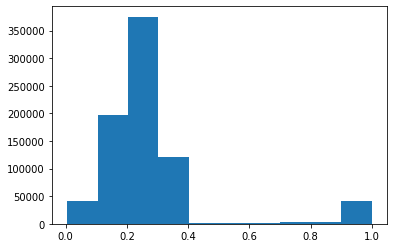

In [6]:
plt.hist(out_numpy[1].reshape(-1))

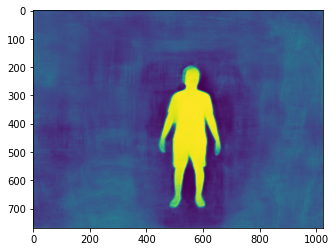

In [9]:
plt.imshow(out_numpy[1,0])
plt.show()

In [9]:
import torch
torch.cuda.empty_cache()

In [4]:
!pwd

/playpen1/qiuyang/refined_segmentation/Nov_4_propagation_try1
